In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ruta del archivo Excel
filePath = '../sdei-annual-pm2-5/sdei-annual-pm2-5-concentrations-countries-urban-areas-v1-1998-2016-xlsx.xlsx'

# Verificar si el archivo existe
if not os.path.exists(filePath):
    print(f"No se encontró el archivo: {filePath}")
    exit()

# Cargar el archivo Excel
excelData = pd.ExcelFile(filePath)

# Mostrar los nombres de las hojas disponibles
sheetNames = excelData.sheet_names
print("Hojas disponibles:", sheetNames)

# Cargar las hojas relevantes en DataFrames
countryPm25ExposureDf = excelData.parse('Country PM2.5 Exposure')
countryPm25ExceedanceDf = excelData.parse('Country PM2.5 Exceedance')
urbanPm25ExposureDf = excelData.parse('Urban PM2.5 Exposure')

Hojas disponibles: ['Title Page', 'Guide', 'Data Dictionary', 'Country PM2.5 Exposure', 'Country PM2.5 Exceedance', 'Urban PM2.5 Exposure']


/home/juan27/.local/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [28]:
countryPm25ExposureDf.sample(5)
filteredColsExpo = ['COUNTRY'] + [col for col in countryPm25ExposureDf.columns if col.startswith('AVPMC_')] 
filteredCountryExpoDf = countryPm25ExposureDf[filteredColsExpo]
filteredCountryExpoDf.sample(5)

,COUNTRY,AVPMC_2008,AVPMC_2009,AVPMC_2010,AVPMC_2011,AVPMC_2012,AVPMC_2013,AVPMC_2014,AVPMC_2015
93,Indonesia,10.301844,11.077192,10.263649,8.409115,12.409657,10.362026,12.725605,16.352763
57,Ecuador,7.066431,7.702704,10.959322,7.348094,14.787105,9.485535,7.304536,7.399344
99,Italy,11.948800,12.575349,12.125207,12.884625,12.258559,11.932498,20.239138,15.720104
144,Netherlands,12.780640,12.649963,15.114855,13.317034,12.872760,10.912828,14.007154,13.360295
13,Azerbaijan,16.581916,14.253608,16.938606,14.845246,15.737084,16.171966,16.929826,20.118499


In [29]:
countriesExpo = filteredCountryExpoDf['COUNTRY'].dropna().drop_duplicates().tolist()
countriesExpo[:10]

['Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia']

In [30]:
countryPm25ExceedanceDf.sample(5)
filteredColsExce = ['COUNTRY'] + [col for col in countryPm25ExceedanceDf.columns if col.startswith('PMEXDC_')]
filteredCountryExceDf = countryPm25ExceedanceDf[filteredColsExce]
filteredCountryExceDf.sample(5)


,COUNTRY,PMEXDC_2008,PMEXDC_2009,PMEXDC_2010,PMEXDC_2011,PMEXDC_2012,PMEXDC_2013,PMEXDC_2014,PMEXDC_2015
118,Macao,98.603065,92.485084,67.359278,59.454108,59.454108,59.454108,67.359278,59.185837
4,Andorra,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
67,Finland,0.000000,0.001298,0.052718,0.000371,0.000000,0.000000,1.513879,0.003720
97,Isle of Man,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
122,Malaysia,13.600950,20.084328,12.085518,11.600570,19.602812,14.522874,17.824281,27.631449


In [31]:
countriesExce = filteredCountryExceDf['COUNTRY'].dropna().drop_duplicates().tolist()
countriesExce[:10]

['Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia']

In [32]:
urbanPm25ExposureDf.sample(5)
filteredColsUrban = ['COUNTRYENG'] + [col for col in urbanPm25ExposureDf.columns if col.startswith('AVPMU_')]
filteredUrbanExpoDf = urbanPm25ExposureDf[filteredColsUrban]
filteredUrbanExpoDf.sample(5)

,COUNTRYENG,AVPMU_1998,AVPMU_1999,AVPMU_2000,AVPMU_2001,AVPMU_2002,AVPMU_2003,AVPMU_2004,AVPMU_2005,AVPMU_2006,AVPMU_2007,AVPMU_2008,AVPMU_2009,AVPMU_2010,AVPMU_2011,AVPMU_2012,AVPMU_2013,AVPMU_2014,AVPMU_2015,AVPMU_2016
10237,China,28.616522,30.260290,29.415362,38.939130,43.448985,57.928986,45.379420,58.127536,63.618261,72.771884,61.566377,58.675942,68.058261,57.903478,58.196232,66.163768,59.699130,63.008985,63.650435
14464,Pakistan,18.373913,17.093478,19.378261,23.926087,23.950000,23.034783,25.808696,23.743478,29.897826,25.245652,26.973913,21.539131,25.541304,20.893478,23.582609,21.376087,23.063044,29.554348,26.171739
11726,China,27.376923,38.007692,29.346153,35.923076,42.784615,51.192308,44.084616,53.023077,63.307693,58.023077,52.384615,56.107692,63.084615,53.700000,48.315385,58.623077,55.446154,64.023076,58.092308
14332,India,75.441509,70.811321,76.198113,83.058490,82.883019,88.054717,90.122642,86.818868,84.990566,90.479245,99.249056,96.715094,87.879245,84.513207,76.032075,91.522641,88.790567,97.132075,113.741510
20821,Brazil,11.971312,11.291803,9.739344,8.879508,9.935246,9.204918,9.980328,10.563115,9.516393,9.354918,8.627049,8.936885,9.350000,10.137705,9.900820,8.989344,9.672951,11.667213,10.444262


In [33]:
countriesUrban = filteredUrbanExpoDf['COUNTRYENG'].dropna().drop_duplicates().tolist()
countriesUrban[:5]

['Greenland',
 'United States of America',
 'Norway',
 'Russia',
 'Wallis and Futuna']

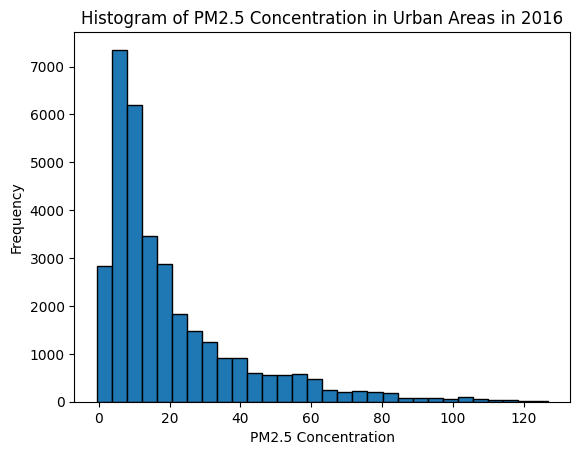

In [34]:
plt.hist(filteredUrbanExpoDf['AVPMU_2016'], bins=30, edgecolor='black')
plt.xlabel('PM2.5 Concentration')
plt.ylabel('Frequency')
plt.title('Histogram of PM2.5 Concentration in Urban Areas in 2016')
plt.show()

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ruta del archivo Excel
filePath = '../sdei-annual-pm2-5/sdei-annual-pm2-5-concentrations-countries-urban-areas-v1-1998-2016-xlsx.xlsx'

# Verificar si el archivo existe
if not os.path.exists(filePath):
    print(f"No se encontró el archivo: {filePath}")
    exit()

# Cargar el archivo Excel
excelData = pd.ExcelFile(filePath)

# Mostrar los nombres de las hojas disponibles
sheetNames = excelData.sheet_names
print("Hojas disponibles:", sheetNames)

# Información de las hojas a cargar y los filtros a aplicar
sheet_info = {
    'Country PM2.5 Exposure': {
        'filter_prefix': 'AVPMC_',
        'filter_cols': ['COUNTRY']
    },
    'Country PM2.5 Exceedance': {
        'filter_prefix': 'PMEXDC_',
        'filter_cols': ['COUNTRY']
    },
    'Urban PM2.5 Exposure': {
        'filter_prefix': 'AVPMU_',
        'filter_cols': ['COUNTRYENG']
    }
}

def load_and_filter_sheet(excel_data, sheet_name, filter_prefix, filter_cols):
    # Cargar la hoja
    df = excel_data.parse(sheet_name)
    # Mostrar una muestra de los datos
    print(f"\nMuestra de '{sheet_name}':")
    print(df.sample(5))
    # Filtrar las columnas
    filtered_columns = filter_cols + [col for col in df.columns if col.startswith(filter_prefix)]
    filtered_df = df[filtered_columns]
    # Mostrar una muestra de los datos filtrados
    print(f"\nMuestra filtrada de '{sheet_name}':")
    print(filtered_df.sample(5))
    return filtered_df

# Diccionario para almacenar los DataFrames filtrados
filtered_dataframes = {}

# Cargar y filtrar cada hoja
for sheet_name, info in sheet_info.items():
    filtered_df = load_and_filter_sheet(
        excelData,
        sheet_name,
        info['filter_prefix'],
        info['filter_cols']
    )
    filtered_dataframes[sheet_name] = filtered_df


Hojas disponibles: ['Title Page', 'Guide', 'Data Dictionary', 'Country PM2.5 Exposure', 'Country PM2.5 Exceedance', 'Urban PM2.5 Exposure']

Muestra de 'Country PM2.5 Exposure':
     CODE  ISO                    COUNTRY  AVPMC_2008  AVPMC_2009  AVPMC_2010  \
56    214  DOM         Dominican Republic    2.740278    2.788850    3.216356   
98    376  ISR                     Israel    8.606946    7.433767    7.423999   
177   666  SPM  Saint Pierre and Miquelon    1.666056    1.448827    1.542132   
23     64  BTN                     Bhutan   20.623154   25.192565   20.588174   
57    218  ECU                    Ecuador    7.066431    7.702704   10.959322   

     AVPMC_2011  AVPMC_2012  AVPMC_2013  AVPMC_2014  AVPMC_2015  
56     2.870366    3.263597    2.886291    2.742242    2.848132  
98     6.747086    7.801801    8.652946    8.521128    9.808137  
177    1.547402    1.474610    1.649704    1.623677    1.652395  
23    18.688219   22.939952   21.832174   24.206670   23.924190  
57   

/home/juan27/.local/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")



Muestra de 'Urban PM2.5 Exposure':
       URBID STNDRDNAME      NAME  ISOURBID        SQKM  \
3944   21524   LAUSANNE  Lausanne  CHE21524  187.992004   
29051  90589       AMTA      AMTA  IND90589   27.965000   
5618   26866    NEWAYGO   Newaygo  USA26866   38.048302   
27947  90281     MANAZO    MANAZO  PER90281   17.052700   
10292  38039       TUBA      Tuba  USA38039  114.425003   

                     COUNTRYENG ISO3  UNSDCODE               CONTINENT  \
3944                Switzerland  CHE       756                  Europe   
29051                     India  IND       356                    Asia   
5618   United States of America  USA       840  Americas-North America   
27947                      Peru  PER       604  Americas-South America   
10292  United States of America  USA       840  Americas-North America   

       AVPMU_1998  ...  AVPMU_2007  AVPMU_2008  AVPMU_2009  AVPMU_2010  \
3944    10.815278  ...   11.951389   12.562500   12.849537   12.362500   
29051   23.79545

In [36]:
# Using kwargs to pass the filters

def filter_disasters_kwargs(df, **kwargs):
    # Check if the country, year, disaster type and geolocation are not None
    for key, value in kwargs.items():
        if value is not None:
            df = df[df[key] == value]
    return df

In [37]:
filter_disasters_kwargs(filteredUrbanExpoDf,COUNTRYENG='Colombia')

,COUNTRYENG,AVPMU_1998,AVPMU_1999,AVPMU_2000,AVPMU_2001,AVPMU_2002,AVPMU_2003,AVPMU_2004,AVPMU_2005,AVPMU_2006,AVPMU_2007,AVPMU_2008,AVPMU_2009,AVPMU_2010,AVPMU_2011,AVPMU_2012,AVPMU_2013,AVPMU_2014,AVPMU_2015,AVPMU_2016
18075,Colombia,1.639130,0.760870,0.560870,1.256522,0.247826,1.213043,0.500000,1.726087,0.734783,0.704348,0.943478,1.152174,0.752174,0.821739,1.091304,0.904348,0.943478,0.939130,1.034783
18193,Colombia,2.154000,0.000000,0.000000,1.276000,0.664000,2.302000,1.850000,3.156000,1.206000,1.598000,1.392000,1.532000,1.556000,1.388000,1.768000,1.722000,1.382000,1.434000,1.470000
18215,Colombia,2.071963,0.137383,0.014953,2.023364,0.757944,2.867290,1.985047,3.574766,1.382243,1.890654,2.000935,2.190654,2.316822,2.175701,2.641122,2.385981,1.976636,2.161682,2.390654
18244,Colombia,3.792029,0.511594,0.099275,2.596377,1.492754,3.577536,2.951449,4.209420,2.211594,2.350725,2.014493,2.241304,2.531159,2.326087,2.902174,2.601449,2.076087,2.342029,2.367391
18255,Colombia,3.925239,0.524282,0.823086,3.639593,2.573565,5.787799,2.563278,3.728469,3.361483,3.178110,2.664354,2.982416,3.046172,2.804426,3.926914,3.197967,3.064474,3.202033,3.680622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27442,Colombia,2.812500,2.800000,3.012500,4.906250,4.406250,4.425000,4.962500,5.043750,4.643750,5.906250,3.381250,3.831250,6.875000,3.243750,9.037500,4.893750,3.868750,4.162500,4.537500
27450,Colombia,3.580000,3.450000,3.300000,4.950000,4.800000,5.100000,4.770000,5.500000,5.210000,6.190000,3.700000,4.540000,6.950000,3.760000,9.670000,5.140000,3.980000,4.700000,4.510000
27458,Colombia,3.308333,3.300000,4.150000,5.366667,5.116667,5.066667,5.791667,5.791667,5.000000,6.975000,3.866667,4.691667,8.341667,3.700000,10.350000,5.550000,4.308334,4.708333,5.450000
27465,Colombia,6.984615,4.446154,10.984615,7.076923,6.215385,7.807692,10.115385,8.407692,7.469231,9.361538,5.515385,4.084615,12.123077,4.315385,9.407692,7.053846,8.100000,4.892308,6.700000


In [38]:
import pandas as pd
import os
import json

# Ruta del archivo Excel
filePath = '../sdei-annual-pm2-5/sdei-annual-pm2-5-concentrations-countries-urban-areas-v1-1998-2016-xlsx.xlsx'

# Verificar si el archivo existe
if not os.path.exists(filePath):
    print(f"No se encontró el archivo: {filePath}")
    exit()

# Cargar el archivo Excel
excelData = pd.ExcelFile(filePath)

# Mostrar los nombres de las hojas disponibles
sheetNames = excelData.sheet_names
print("Hojas disponibles:", sheetNames)

# Información de las hojas a cargar y los filtros a aplicar
sheet_info = {
    'Country PM2.5 Exposure': {
        'filter_prefix': 'AVPMC_',
        'filter_cols': ['COUNTRY']
    },
    'Country PM2.5 Exceedance': {
        'filter_prefix': 'PMEXDC_',
        'filter_cols': ['COUNTRY']
    },
    'Urban PM2.5 Exposure': {
        'filter_prefix': 'AVPMU_',
        'filter_cols': ['COUNTRYENG']
    }
}

def load_and_filter_sheet(excel_data, sheet_name, filter_prefix, filter_cols):
    # Cargar la hoja
    df = excel_data.parse(sheet_name)
    # Filtrar las columnas
    filtered_columns = filter_cols + [col for col in df.columns if col.startswith(filter_prefix)]
    filtered_df = df[filtered_columns]
    return filtered_df

# Diccionario para almacenar los DataFrames filtrados
filtered_dataframes = {}

# Cargar y filtrar cada hoja
for sheet_name, info in sheet_info.items():
    filtered_df = load_and_filter_sheet(
        excelData,
        sheet_name,
        info['filter_prefix'],
        info['filter_cols']
    )
    filtered_dataframes[sheet_name] = filtered_df

# Función para filtrar datos utilizando **kwargs
def filter_data(df, **filters):
    # Filtrar el DataFrame según los argumentos proporcionados
    for key, value in filters.items():
        if value is not None and key in df.columns:
            df = df[df[key] == value]
    return df

# Funciones para retornar datos en formato JSON
def get_data_as_json(sheet_name, **filters):
    df = filtered_dataframes.get(sheet_name)
    if df is not None:
        filtered_df = filter_data(df, **filters)
        return filtered_df.to_json(orient='records')
    else:
        return json.dumps([])

# Ejemplos de uso:

# Obtener datos de exposición PM2.5 por país para Colombia
json_data = get_data_as_json('Country PM2.5 Exposure', COUNTRY='Colombia')
print(json_data)

# Obtener datos de excedencia PM2.5 por país para Colombia
json_data_exceedance = get_data_as_json('Country PM2.5 Exceedance', COUNTRY='Colombia')
print(json_data_exceedance)

# Obtener datos de exposición PM2.5 urbana para Medellín, Colombia
json_data_urban = get_data_as_json('Urban PM2.5 Exposure', COUNTRYENG='Colombia')
print(json_data_urban)

# Función para obtener listas de valores únicos (por ejemplo, lista de países)
def get_unique_values(sheet_name, column_name):
    df = filtered_dataframes.get(sheet_name)
    if df is not None and column_name in df.columns:
        return df[column_name].dropna().drop_duplicates().tolist()
    else:
        return []

# Obtener lista de países únicos en 'Country PM2.5 Exposure'
countries_exposure = get_unique_values('Country PM2.5 Exposure', 'COUNTRY')
print(countries_exposure[:10])



Hojas disponibles: ['Title Page', 'Guide', 'Data Dictionary', 'Country PM2.5 Exposure', 'Country PM2.5 Exceedance', 'Urban PM2.5 Exposure']


/home/juan27/.local/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


[{"COUNTRY":"Colombia","AVPMC_2008":6.5176484937,"AVPMC_2009":7.4727359403,"AVPMC_2010":9.7057362387,"AVPMC_2011":6.3935288919,"AVPMC_2012":9.9906223802,"AVPMC_2013":8.2327534953,"AVPMC_2014":7.6382660527,"AVPMC_2015":7.1180866308}]
[{"COUNTRY":"Colombia","PMEXDC_2008":2.4556198785,"PMEXDC_2009":2.8382164135,"PMEXDC_2010":8.6384392154,"PMEXDC_2011":2.3437387644,"PMEXDC_2012":8.8354609218,"PMEXDC_2013":5.9500808999,"PMEXDC_2014":2.9659934105,"PMEXDC_2015":2.6041372727}]
[{"COUNTRYENG":"Colombia","AVPMU_1998":1.6391304161,"AVPMU_1999":0.7608695691,"AVPMU_2000":0.5608695664,"AVPMU_2001":1.2565217381,"AVPMU_2002":0.2478260955,"AVPMU_2003":1.213043472,"AVPMU_2004":0.500000011,"AVPMU_2005":1.7260869534,"AVPMU_2006":0.7347826154,"AVPMU_2007":0.7043478282,"AVPMU_2008":0.9434782681,"AVPMU_2009":1.1521739182,"AVPMU_2010":0.7521739136,"AVPMU_2011":0.8217391268,"AVPMU_2012":1.0913043515,"AVPMU_2013":0.9043478266,"AVPMU_2014":0.9434782681,"AVPMU_2015":0.939130441,"AVPMU_2016":1.034782604},{"COUNTRY

In [39]:
# Filtros recibidos desde la interfaz web
user_filters = {
    'COUNTRY': 'Colombia',  # Por ejemplo, seleccionado por el usuario
}

# Obtener los datos filtrados en formato JSON
json_response = get_data_as_json('Country PM2.5 Exposure', **user_filters)

# Enviar 'json_response' como respuesta a la solicitud web
json_response

'[{"COUNTRY":"Colombia","AVPMC_2008":6.5176484937,"AVPMC_2009":7.4727359403,"AVPMC_2010":9.7057362387,"AVPMC_2011":6.3935288919,"AVPMC_2012":9.9906223802,"AVPMC_2013":8.2327534953,"AVPMC_2014":7.6382660527,"AVPMC_2015":7.1180866308}]'